In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense,Flatten, Dropout
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D 
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.datasets import cifar100
import cv2
import albumentations as albu
import seaborn as sns

In [2]:
#menghubungkan ke google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#mengambil data dari cifar 100
#berisi objek random sebanyak 100 kelas masing masing kelas berisi 500 sample foto
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

169001437/169001437 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
#Global Parameter
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
classes = 100

epochs = 50
batch_size = 8
lr = 1e-3


In [65]:
#label label untuk setiap kelas
label_list =  ['Buah Apel', 'Ikan', 'Bayi', 'Beruang', 'Berang-berang', 'Tempat Tidur', 'Lebah(serangga)', 'Kumbang(serangga)', 'Sepeda', 'Botol', 'Mangkuk', 'Anak Laki-Laki', 'Jembatan', 'Bus', 'Kupu-Kupu', 
                    'Unta', 'Kaleng', 'Istana(Benteng)', 'Ulat', 'Hewan Ternak', 'Kursi', 'Orang hutan', 'Jam', 'Awan(langit)', 'Kecoa(serangga)', 'Sofa', 'Kepiting', 'Buaya', 'Cangkir', 
                    'Dinosaurus', 'Lumba-lumba', 'Gajah', 'Ikan Laut', 'Hutan', 'Rubah', 'Anak Perempuan', 'Hamster', 'Rumah', 'Kanguru', 'Keyboard', 
                    'Lampu', 'Mesin Pemotong Rumput', 'Macan Tutul', 'Singa', 'Kadal', 'Lobster', 'Pria', 'Pohon', 'Sepeda Motor', 'Gunung', 'Tikus', 'Jamur', 
                    'Pohon', 'Buah Jeruk', 'Bunga Anggrek', 'Berang-berang', 'Pohon', 'Buah pir', 'Mobil Pickup', 'Pohon', 'Hamparan Tanah', 'Piring', 'Bunga', 'Landak', 'Posum', 
                    'Kelinci', 'Rakun', 'Sinar', 'Jalan', 'Roket', 'Bunga Mawar', 
                    'Laut', 'Anjing Laut', 'Hiu', 'Tikus', 'Tupai', 'Menara', 'Siput', 'Ular', 'Laba-laba', 'Tupai', 'Jalanan Mobil', 'Bunga Matahari', 'Lada', 
                    'Meja', 'Tank', 'Telephone', 'Televisi', 'Harimau', 'Traktor', 'Kereta', 'Ikan', 'Bunga', 'Kura-kura', 
                    'Lemari Pakaian', 'Paus', 'Pohon', 'Serigala', 'Wanita', 'Cacing']

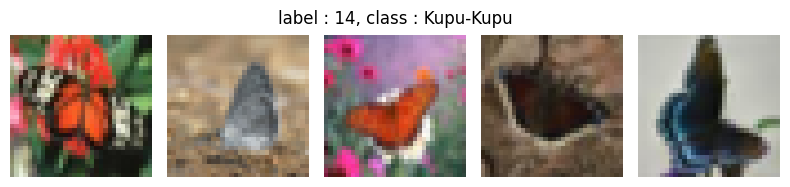

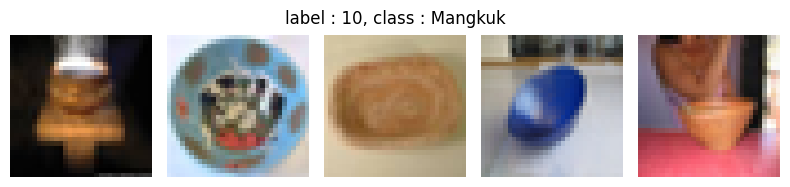

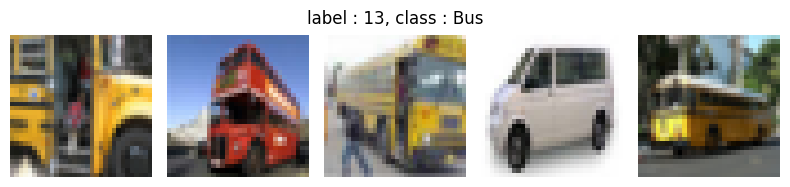

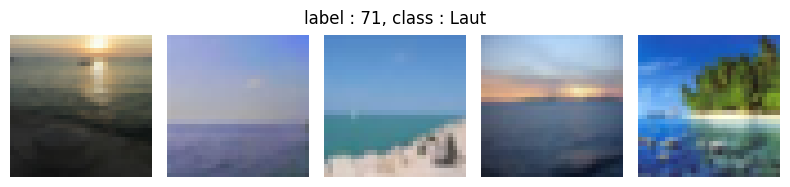

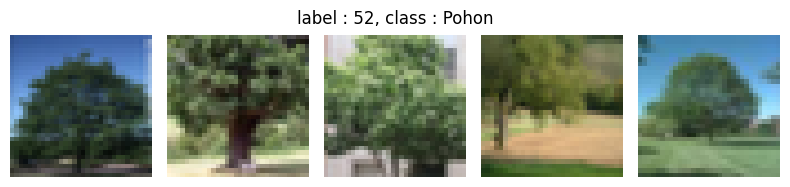

In [71]:
#menampilkan gambar 5 tiap kelas secara random
class_plotted = np.random.choice(range(classes), 5, replace = False)

for i in range(len(class_plotted)):
    image_samples = x_train[y_train.reshape(-1) == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (8,8))
    fig.suptitle("label : %d, class : %s" % (class_plotted[i], label_list[class_plotted[i]]), y = .6)
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show()

In [72]:
#pre processing gambar ke numpy array dan kategorikal untuk label
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = to_categorical(np.array(y_train), 100)
y_test = to_categorical(np.array(y_test), 100)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(50000, 32, 32, 3)
(50000, 100)
(10000, 32, 32, 3)
(10000, 100)


In [73]:
#split data training menjadi data training dan validasi
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=100)

for train_index, val_index in sss.split(x_train, y_train):
    X_train_data, X_val_data = x_train[train_index], x_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Number of training samples:  40000
Number of validation samples:  10000


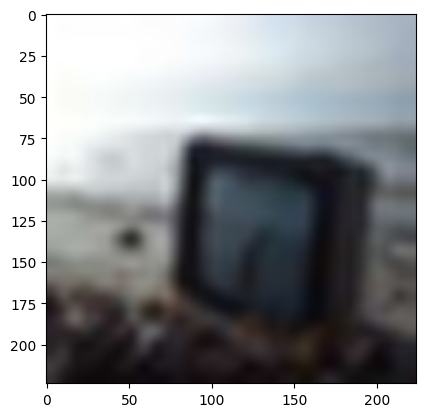

In [75]:
"""
untuk ukuran gambar (32, 32, 3) akurasi hanya mencapai ~67%
setiap gambar akan dirubah menjadi ukuran standar pemrosesan (224, 224)
"""
def resize_img(img, shape):
  """
  img : berisi array suatu gambar
  shape : ukuran gambar setelah di ubah
  return: gambar hasil perubahan ukuran
  """
  return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

#contoh resize
plt.imshow(resize_img(x_train[52], (224, 224)))
plt.show()

In [76]:
#DataGenerator class untuk pre processing gambar
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), channels=channels, n_classes=classes, shuffle=True, augment=False):
        
        #parameter konfigurasi
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method untuk setiap epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return banyaknya step setiap epoch
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #pre -processing setiap gambar
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
      
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            img = self.images[ID]
            #rescale
            img = img.astype(np.float32)/255.
            #resize
            img = resize_img(img, self.dim)
            X[i] = img
            
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentasi 
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentasi untuk setiap gambar
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    #augmentasi untuk setiap batch gambar
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch
    

In [77]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True)
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

# Model Pertama : CNN

In [78]:
#model pertama : CNN
model_cnn=Sequential()
model_cnn.add(layers.Conv2D(32,(3,3),padding='same',activation='relu',input_shape=input_shape))
model_cnn.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn.add(layers.MaxPool2D())
model_cnn.add(layers.Dropout(0.25))
model_cnn.add(layers.Conv2D(64,(3,3),padding='same',activation='relu'))
model_cnn.add(layers.MaxPool2D())
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Conv2D(128,(3,3),padding='same',activation='relu'))
model_cnn.add(layers.MaxPool2D())
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(512,activation='relu'))
model_cnn.add(layers.Dense(100,activation='softmax'))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

In [ ]:
optimizer = Adam(learning_rate=0.0001)

#early stopping untuk memonitor valdasi accurasi dan menghindari overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#pengurangan learning rate
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

model_cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model_history=model_cnn.fit(train_data_generator,
                                    validation_data=valid_data_generator,
                                    callbacks=[early_stop, rlrop],
                                    verbose=1,
                                    epochs=epochs)

"""
model cnn hanya mencapai akurai ~64% pada training dan ~58% pada validasi
"""

# Model 2 : Menggunakan Transfer Learning
EfficientNet termasuk salah satu teknik transfer learning yang dikhususkan untuk masalah pengenalan objek atau klasifikasi gambar

Hasil akurasi dari EfficientNet lebih tinggi
dibandingkan dengan pre-trained model yang lain dengan jumlah parameter
yang lebih sedikit.

sumber: https://kc.umn.ac.id/17326/4/BAB_II.pdf

In [80]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
#secnd model using transfer learning
import efficientnet.keras as efn

efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))


16804768/16804768 [==============================] - 1s 0us/step


In [ ]:
optimizer = Adam(learning_rate=0.0001)


early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)


rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_data_generator,
                                    validation_data=valid_data_generator,
                                    callbacks=[early_stop, rlrop],
                                    verbose=1,
                                    epochs=25)

Epoch 1/25
5000/5000 [==============================] - 725s 142ms/step - loss: 2.6815 - accuracy: 0.3356 - val_loss: 1.1020 - val_accuracy: 0.6681 - lr: 1.0000e-04
Epoch 2/25
5000/5000 [==============================] - 701s 140ms/step - loss: 1.6421 - accuracy: 0.5462 - val_loss: 0.9252 - val_accuracy: 0.7290 - lr: 1.0000e-04
Epoch 3/25
5000/5000 [==============================] - 705s 141ms/step - loss: 1.3595 - accuracy: 0.6209 - val_loss: 0.8425 - val_accuracy: 0.7602 - lr: 1.0000e-04
Epoch 4/25
5000/5000 [==============================] - 700s 140ms/step - loss: 1.1854 - accuracy: 0.6634 - val_loss: 0.8038 - val_accuracy: 0.7756 - lr: 1.0000e-04
Epoch 5/25
5000/5000 [==============================] - 712s 142ms/step - loss: 1.0552 - accuracy: 0.6979 - val_loss: 0.8242 - val_accuracy: 0.7821 - lr: 1.0000e-04
Epoch 6/25
5000/5000 [==============================] - 705s 141ms/step - loss: 0.9755 - accuracy: 0.7187 - val_loss: 0.7999 - val_accuracy: 0.7880 - lr: 1.0000e-04
Epoch 7/25

In [ ]:
#save model
model.save('model.h5')

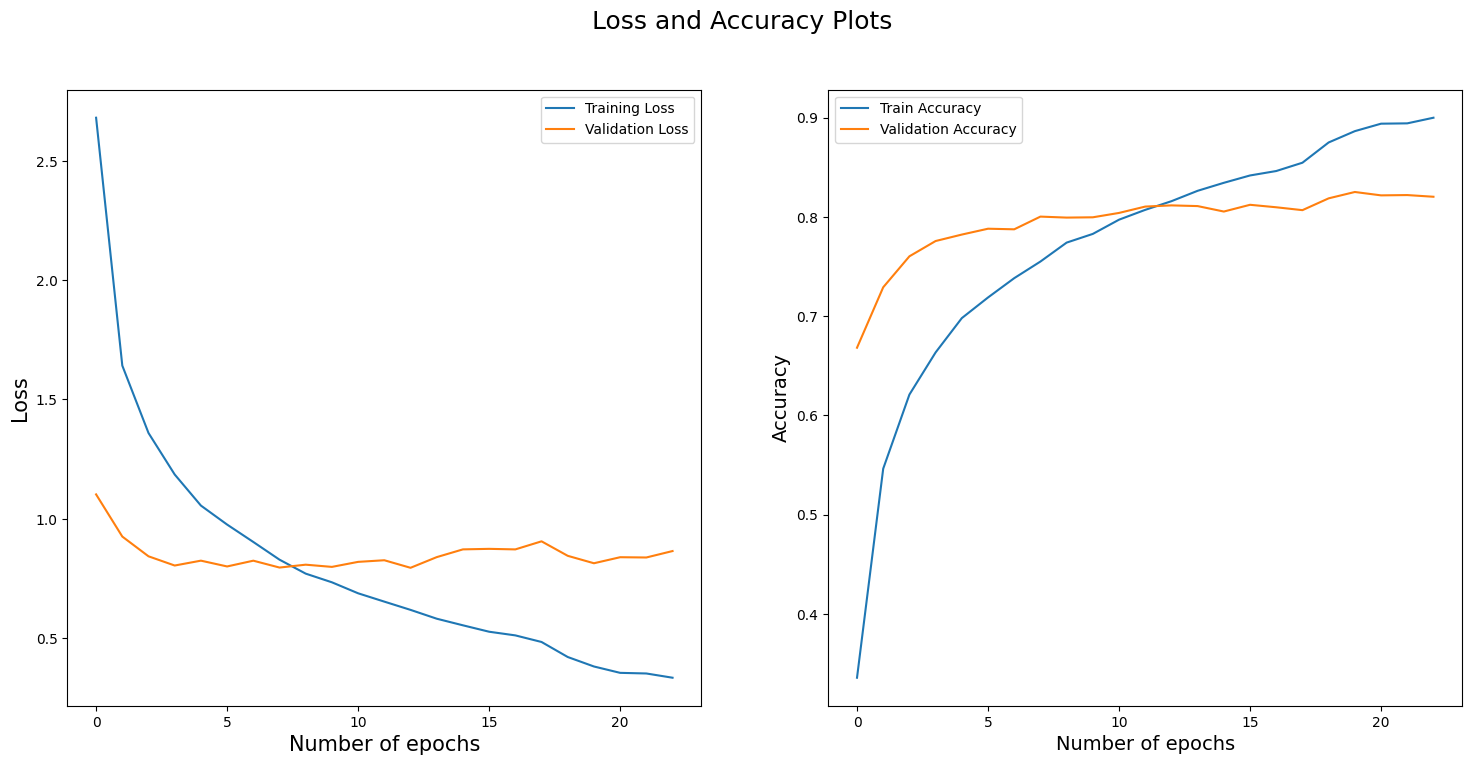

In [ ]:
#grafik loss dan akurasi
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
#akurasi validasi dataset
valid_loss, valid_accuracy = model.evaluate(valid_data_generator, verbose=1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

1250/1250 [==============================] - 26s 21ms/step - loss: 0.7943 - accuracy: 0.8115
Validation Accuracy:  81.15 %


In [81]:
from keras.models import load_model
from efficientnet.tfkeras import EfficientNetB4

saved_model = load_model('/content/drive/MyDrive/capstone/model.h5')

In [82]:
#akurasi pada test dataset
y_pred = saved_model.predict(DataGenerator(x_test, mode='predict', augment=False, shuffle=False), verbose=1)
y_pred = np.argmax(y_pred, axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

1250/1250 [==============================] - 47s 26ms/step
Test Accuracy:  80.5 %


In [83]:
#confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)

[[95  0  0 ...  0  0  0]
 [ 0 89  0 ...  0  0  0]
 [ 0  0 73 ...  0  4  0]
 ...
 [ 0  0  0 ... 85  0  0]
 [ 0  0  4 ...  0 68  0]
 [ 0  0  0 ...  0  0 87]]


In [84]:
#classification report
target = ["Category {}".format(i) for i in range(classes)]
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target))

              precision    recall  f1-score   support

  Category 0       0.84      0.95      0.89       100
  Category 1       0.91      0.89      0.90       100
  Category 2       0.65      0.73      0.69       100
  Category 3       0.77      0.63      0.69       100
  Category 4       0.77      0.63      0.69       100
  Category 5       0.86      0.74      0.80       100
  Category 6       0.87      0.85      0.86       100
  Category 7       0.84      0.84      0.84       100
  Category 8       0.98      0.94      0.96       100
  Category 9       0.97      0.90      0.93       100
 Category 10       0.65      0.53      0.59       100
 Category 11       0.53      0.52      0.52       100
 Category 12       0.87      0.87      0.87       100
 Category 13       0.80      0.66      0.72       100
 Category 14       0.92      0.86      0.89       100
 Category 15       0.93      0.79      0.85       100
 Category 16       0.81      0.86      0.83       100
 Category 17       0.92    

In [85]:
labels = {
    'Classes': label_list
}
categories = pd.DataFrame(labels)
categories

,Classes
0,Buah Apel
1,Ikan
2,Bayi
3,Beruang
4,Berang-berang
...,...
95,Paus
96,Pohon
97,Serigala
98,Wanita


In [86]:
prediction = pd.DataFrame(y_pred)
prediction.head()

,0
0,68
1,33
2,55
3,51
4,71


Predicted Label: Buah


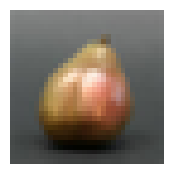

In [101]:
imageId = np.random.randint(0, len(x_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(x_test[imageId])

plt.axis('off')

#print("True Label: " + str(subCategory.iloc[testData['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(categories.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

#pengecekan ke gambar random

In [103]:
def resize_test_image(test_img):

    img = cv2.imread(test_img)
    #plt.imshow(img)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_RGB)
    resized_img = cv2.resize(img_RGB, (224, 224))
    #plt.imshow(resized_img)
    resized_img = resized_img / 255.
    #plt.imshow(resized_img)
    return resized_img

In [104]:
def predict_test_image(test_img):
    
    resized_img = resize_test_image(test_img)
    prediction = saved_model.predict(np.array([resized_img]))
    
    return prediction

In [105]:
def sort_prediction_test_image(test_img):
    
    prediction = predict_test_image(test_img)
    
    index = np.arange(0,100)
    
    for i in range(100):
        for j in range(100):
            if prediction[0][index[i]] > prediction[0][index[j]]:
                temp = index[i]
                index[i] = index[j]
                index[j] = temp
                
    return index

In [106]:
def df_top5_prediction_test_image(test_img):
    
    sorted_index = sort_prediction_test_image(test_img)
    prediction = predict_test_image(test_img)
    
    subCategory_name = []
    prediction_score = []
    
    k = sorted_index[:6] 
    
    for i in range(len(k)):
        subCategory_name.append(categories.iloc[k[i]][0])
        prediction_score.append(round(prediction[0][k[i]], 2))
        
    df = pd.DataFrame(list(zip(subCategory_name, prediction_score)), columns=['Label', 'Probability'])  
    
    return df

In [107]:
def plot_top5_prediction_test_image(test_img):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle("Prediction", fontsize=18)
    
    new_img = plt.imread(test_img)
    axes[0].imshow(new_img)
    axes[0].axis('off')
    
    data = df_top5_prediction_test_image(test_img)
    x=df_top5_prediction_test_image(test_img)['Label']
    y=df_top5_prediction_test_image(test_img)['Probability']
    
    axes[1] = sns.barplot(x=x, y=y, data=data, color="green")
    
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    
    plt.ylim(0,1.0)
    
    axes[1].grid(False)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)
    axes[1].spines["left"].set_visible(False)
    
    plt.show()

1/1 [==============================] - 0s 36ms/step


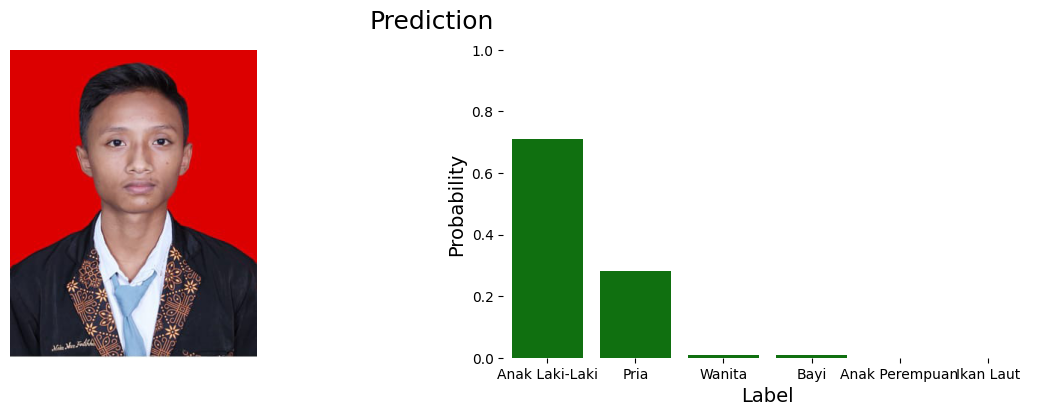

In [108]:
plot_top5_prediction_test_image('/content/drive/MyDrive/Kamera/1602332138-picsay.jpg')

1/1 [==============================] - 0s 28ms/step


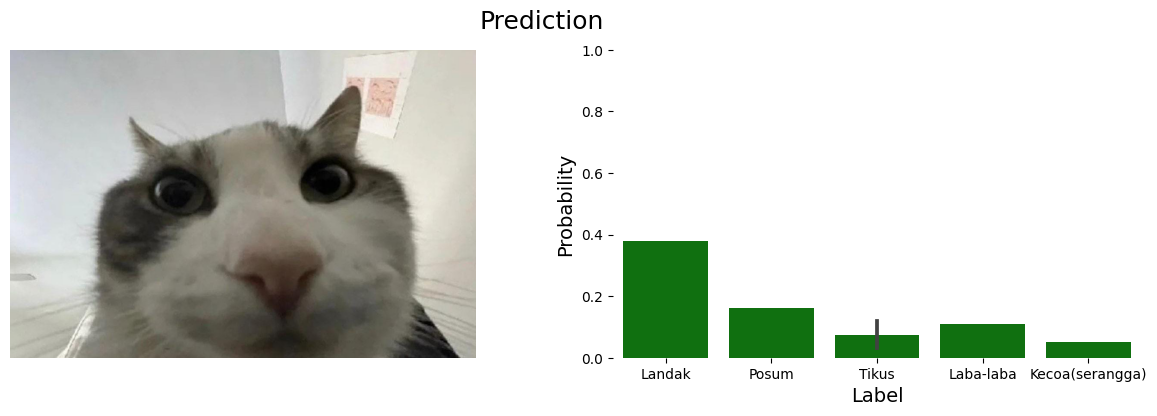

In [109]:
plot_top5_prediction_test_image('/content/drive/MyDrive/Kamera/thoriq.jpg')

1/1 [==============================] - 0s 44ms/step


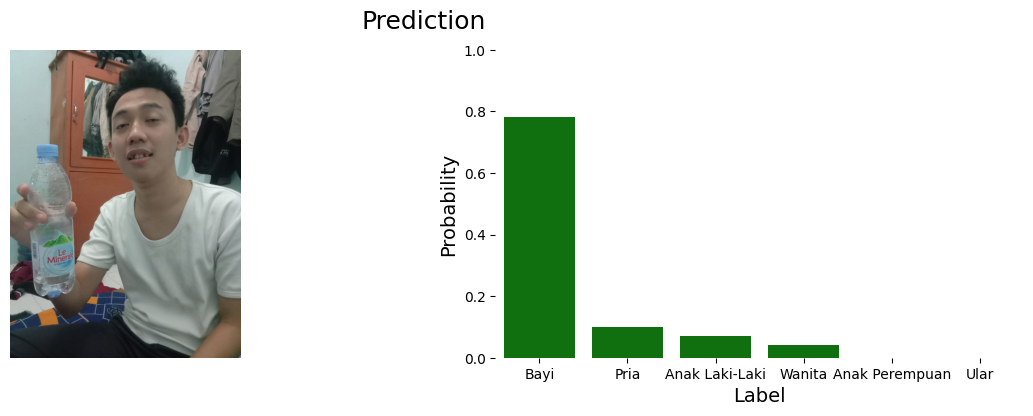

In [110]:
plot_top5_prediction_test_image('/content/drive/MyDrive/Kamera/alipwithbotol.jpg')

1/1 [==============================] - 0s 28ms/step


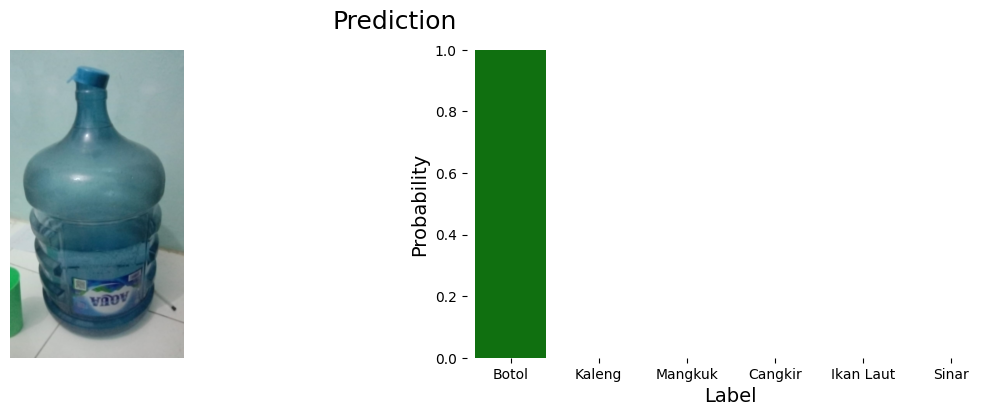

In [111]:
gallon = '/content/drive/MyDrive/capstone/gallon.jpg'
plot_top5_prediction_test_image(gallon)


1/1 [==============================] - 0s 98ms/step


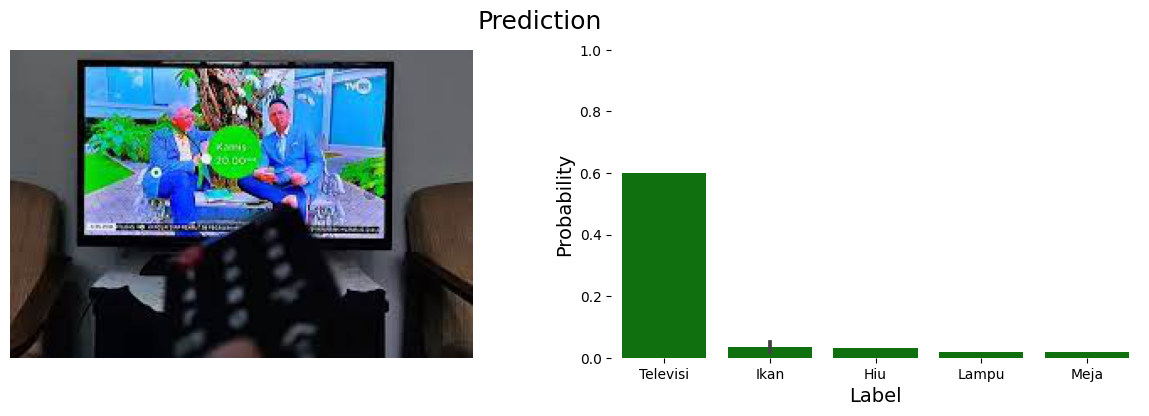

In [113]:
tv = '/content/drive/MyDrive/capstone/download.jpg'
plot_top5_prediction_test_image(tv)

#convert ke tflite

In [114]:
path_saved_model = 'myfolder_saved_model'

tf.saved_model.save(saved_model, path_saved_model)

In [115]:
%%bash -s $path_saved_model
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['efficientnet-b0_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_efficientnet-b0_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-06-08 14:27:31.318537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [116]:
loaded = tf.saved_model.load(path_saved_model)

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'efficientnet_b0_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='efficientnet-b0_input')})
{'dense': TensorSpec(shape=(None, 100), dtype=tf.float32, name='dense')}


In [117]:
converter = tf.lite.TFLiteConverter.from_saved_model(path_saved_model)

In [118]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [119]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(label_list))

In [120]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#convert tfjs

In [121]:
!pip install tensorrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1-py2.py3-none-any.whl size=16973 sha256=c5e248f4ba076e853ced2cd6ea99e1cfdc59c4340a1d1bb021368b0f19d34fb6
  Stored in directory: /root/.cache/pip/wheels/6d/29/56/abdffd4c604f255b5254bef3f1c598ab7811ea020540599438
Successfully built tensorrt


In [122]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [ ]:
path_modelh5 = '/content/drive/MyDrive/capstone/model.h5'

In [ ]:
!tensorflowjs_converter --input_format=keras {path_modelh5} ./

2023-06-07 07:38:26.437261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
